In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_validate

In [4]:
dataset_folder = "../all"
!ls {dataset_folder}

data_note.pdf	       test_set_metadata.csv  training_set_metadata.csv
sample_submission.csv  test_set_sample.csv
test_set.csv	       training_set.csv


In [5]:
metadata = pd.read_csv(f"{dataset_folder}/training_set_metadata.csv")
metadata.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


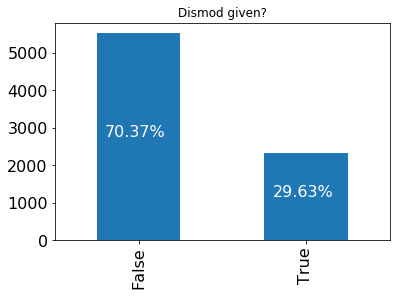

In [6]:
ax = metadata.distmod.isna().value_counts().plot.bar(fontsize=16, title="Dismod given?");
for p in ax.patches:
    ax.annotate(f"{round(p.get_height()*100/metadata.shape[0], 2)}%", (p.get_x()-0.2+p.get_width()/2, p.get_height() / 2), color="w", fontsize=16)

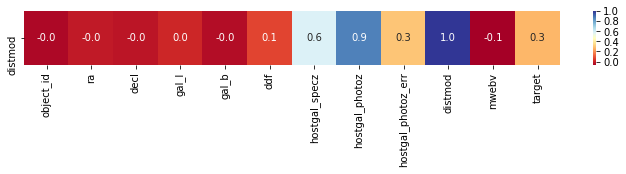

In [26]:
plt.figure(figsize=(12,1))
sns.heatmap(metadata.corr().loc['distmod':'distmod'], annot=True, fmt=".1f", cmap="RdYlBu");

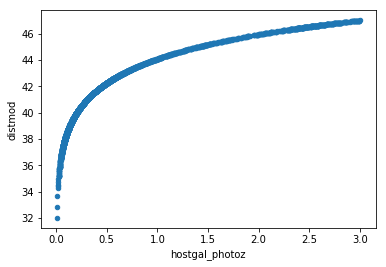

In [75]:
ds_distmod = metadata[~metadata.distmod.isna()]
ds_distmod.plot.scatter(x="hostgal_photoz", y="distmod");

In [133]:
X1 = ds_distmod[["hostgal_photoz", "hostgal_photoz_err"]]
X1.loc[:, "photoz_squared"] = ds_distmod.hostgal_photoz * ds_distmod.hostgal_photoz
X1.loc[:, "photoz_sqrt"] = np.sqrt(ds_distmod.hostgal_photoz)
y = ds_distmod.distmod
X1.loc[:, :] = (X1 - X1.min())/(X1.max() - X1.min())
X1.head()

/home/frankl1/.env/plasticc/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/frankl1/.env/plasticc/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/frankl1/.env/plasticc/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

,hostgal_photoz,hostgal_photoz_err,photoz_squared,photoz_sqrt
1,0.541455,0.146319,0.294132,0.724316
2,0.073624,0.008135,0.005684,0.241253
3,0.092030,0.663916,0.008792,0.274334
4,0.078735,0.009231,0.006479,0.250809
6,0.058859,0.016617,0.003678,0.211664


In [92]:
def plot_predictions(ds, y_pred):
#     ds_distmod.plot.scatter(x="hostgal_photoz", y="distmod", c="b", label="true")
#     ds_distmod.plot.scatter(x="hostgal_photoz", y=y_pred, c="g", label="predited")
    plt.scatter(x=ds.hostgal_photoz, y=ds.distmod, label="true values")
    plt.scatter(x=ds.hostgal_photoz, y=ds[y_pred], label="predictions")
    plt.ylabel("Distmod")
    plt.xlabel("Hostgal_specz")
    plt.legend()

In [30]:
def get_best(model, X, y):
    cv_result = cross_validate(model, X, y, cv=10,return_estimator=True, scoring="neg_mean_squared_log_error")
    best_index = np.argmax(cv_result["test_score"])
    print(f"Mean Absolute Log Error: {-cv_result['test_score'][best_index]}")
    return cv_result["estimator"][best_index]

Mean Absolute Log Error: 3.7471671464863853e-06
Coef [-2.65861821e+01  4.53419100e-03  8.05153468e+00  3.13781009e+01]


/home/frankl1/.env/plasticc/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


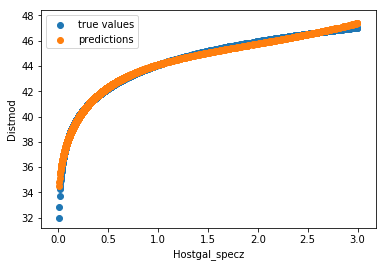

In [134]:
lg_model = LinearRegression()
lg_model = get_best(lg_model, X1, y)
print("Coef", lg_model.coef_)
ds_distmod["lg_pred"] = lg_model.predict(X1)
plot_predictions(ds_distmod, "lg_pred")

Mean Absolute Log Error: 2.3533313182192836e-05
Coef [-5.18542806  0.22668894 -3.36879152 18.92742451]


/home/frankl1/.env/plasticc/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


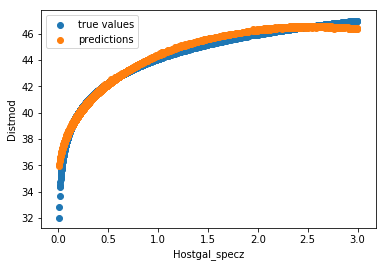

In [135]:
ridge_model = Ridge(alpha=0.9)
ridge_model = get_best(ridge_model, X1, y)
print("Coef", ridge_model.coef_)
ds_distmod["pred"] = ridge_model.predict(X1)
plot_predictions(ds_distmod, "pred")